In [1]:
import functools

import jax.numpy as jnp
import jax.random as jrd
from jax import jit

import parametrization_cookbook.jax as pc
import sdg4varselect.plotting as sdgplt

sdgplt.FIGSIZE = 4

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
def plot_sample(obs, sim, censoring_loc, a, b):
    fig = sdgplt.figure(7, 7)

    ax = fig.add_subplot(211)
    ax.plot(obs["mem_obs_time"].T, obs["Y"].T, "o-")

    ax = fig.add_subplot(212)
    ax.hist(
        [obs["T"], sim["T uncensored"]],  # , sim["C"]],
        bins=20,
        density=True,
        label=["censored survival time", "survival time"],  # , "censuring time"],
    )

    def weibull_fct(t, a, b):
        return b / a * (t / a) ** (b - 1) * jnp.exp(-((t / a) ** b))

    t = jnp.linspace(
        obs["T"].min(), max(obs["T"].max(), sim["T uncensored"].max()), num=1000
    )
    ax.plot(t, weibull_fct(t, a, b), label="weibull baseline")

    ax.plot(
        t,
        weibull_fct(t, censoring_loc, 10),
        label="censured time weibull distribution",
    )
    ax.legend()

    # print(f'censoring = {int((1-obs["delta"].mean())*100)}%')

    fig.suptitle(f'Simulation with {int((1-obs["delta"].mean())*100)}% censored data')
    return fig, ax

### Joint Model Specification

$$ \left\{\begin{array}{rll}
            h(t|U_i) 
            &=h_{0}(t) \exp(\beta^T U_i + \alpha m(t,\varphi_i))
            \\ Y_{i,j} &= m(t_j; \varphi_i) + \varepsilon_{i,j}
            \\ \varphi_i \sim \mathcal N(\mu, \Gamma)   
            & ; ~\varepsilon_{i,j} \sim \mathcal N(0,\sigma^2).             
        \end{array}\right. ~ \forall i \in\{1,...,N\}, j\in\{1,...,J\}$$

where : $h_{0}(t)= b a^{-b} t^{b-1}$ with $a=80$ and $b=35$

#### NLMEM Specification

First, let's define the model with the abstract object AbstractMixedEffectsModel. We want to define the following logisitc models :

$$ \left\{\begin{array}{rll}
            Y_{i,j} &= m(t_{i,j}; \varphi_i) + \varepsilon_{i,j}
            \\ \varphi_i \sim \mathcal N(\mu, \Gamma)   
            & ; ~\varepsilon_{i,j} \sim \mathcal N(0,\sigma^2).             
        \end{array}\right. ~ \forall i \in\{1,...,N\}, j\in\{1,...,J\}$$

where : $m(t_{i,j}; \varphi) = \frac{\varphi_{1,i}}{1+\exp\left(\frac{\varphi_{2,i}-t_{i,j}}{\tau} \right)}$ 

In [3]:
from sdg4varselect.models import AbstractMixedEffectsModel


def m(params, times, phi1, phi2, **kwargs):
    phi1 += params.mean_latent.mu_1
    phi2 += params.mean_latent.mu_2

    out = phi1[:, None] / (1 + jnp.exp(-(times - phi2[:, None]) / params.tau))
    assert out.shape == times.shape
    return out

In [4]:
class LogisticMixedEffectsModel(AbstractMixedEffectsModel):
    """define a logistic mixed effects model"""

    def __init__(self, N=1, J=1, **kwargs):
        AbstractMixedEffectsModel.__init__(self, N=N, J=J, **kwargs)
        self.add_latent_variables("phi1")
        self.add_latent_variables("phi2")

    @property
    def name(self):
        return f"LogisticMEM_N{self.N}_J{self.J}"

    def init_parametrization(self):
        """here you define the parametrization of the model
        and don't forget to call the mother init function at the end"""

        self._parametrization = pc.NamedTuple(
            mean_latent=pc.NamedTuple(
                mu_1=pc.RealPositive(scale=100),
                mu_2=pc.Real(loc=100, scale=100),
            ),
            tau=pc.RealPositive(scale=100),
            cov_latent=pc.MatrixDiagPosDef(dim=2, scale=(200, 200)),
            var_residual=pc.RealPositive(scale=100),
        )
        self.parametrization_size = self._parametrization.size

    # ============================================================== #
    @functools.partial(jit, static_argnums=0)
    def mixed_effect_function(self, params, *args, **kwargs) -> jnp.ndarray:
        return m(params, *args, **kwargs)

    # ============================================================== #

    def sample(self, params_star, prngkey, **kwargs):
        (prngkey_time, prngkey_mem) = jrd.split(prngkey, num=2)

        # === nlmem_simulation() === #
        time = jnp.linspace(100, 1500, self.J)
        time = jnp.tile(time, (self.N, 1))

        obs, sim = AbstractMixedEffectsModel.sample(
            self, params_star, prngkey_mem, mem_obs_time=time
        )

        return {"mem_obs_time": time} | obs, sim

#### Survival Model

In [5]:
from sdg4varselect.models.abstract.abstract_cox_model import AbstractCoxModel

In [6]:
class WeibullCoxModel(AbstractCoxModel):
    @property
    def name(self):
        return f"CoxModel{self.N}_P{self.P}"

    def init_parametrization(self):
        self._parametrization = pc.NamedTuple(
            # a=pc.Real(loc=400, scale=100),
            # b=pc.RealPositive(scale=1),
            beta=pc.Real(scale=1, shape=(self.P,)),
        )

    # ============================================================== #

    @functools.partial(jit, static_argnums=0)
    def proportional_hazards_component(self, params, cov, **kwargs):
        return (cov @ params.beta)[:, None]

    @functools.partial(jit, static_argnums=0)
    def log_baseline_hazard(self, params, survival_int_range, a, b, *args, **kwargs):
        """Function that return the log of the baseline hazard
        log(b/a* (t/a)^(b-1)) = log(b/a) + (b-1) log(t/a)
        """
        # a = params.a
        # b = params.b

        out = jnp.log(b / a) + (b - 1) * jnp.log(survival_int_range / a)
        assert out.shape == survival_int_range.shape
        return out

    # ============================================================== #
    def censoring_simulation(self, prngkey, T, params_star, **kwargs):
        return T.max()

        # jrd.weibull_min(
        #         prngkey,
        #         kwargs["weibull_censoring_loc"],
        #         self._cst["b"] if "b" in self._cst else params_star.b,
        #         shape=T.shape,
        #     )

    # ============================================================== #
    def covariates_simulation(self, prngkey, **kwargs) -> jnp.ndarray:
        return jrd.uniform(prngkey, minval=-1, maxval=1, shape=(self.N, self.P))

#### Joint Model

In [7]:
from sdg4varselect.models.abstract.abstract_cox_mem_joint_model import (
    AbstractCoxMemJointModel,
)

In [8]:
class WeibullCoxMemJointModel(AbstractCoxMemJointModel):
    def __init__(self, N, J, P, alpha_scale, **kwargs):
        mem = LogisticMixedEffectsModel(N=N, J=J)
        cox = WeibullCoxModel(N=N, P=P)
        AbstractCoxMemJointModel.__init__(self, mem, cox, alpha_scale, **kwargs)

    @property
    def name(self):
        return f"WCoxMemJM_N{self.N}_J{self.J}_P{self.P}"

    # ============================================================== #
    @functools.partial(jit, static_argnums=0)
    def link_function(self, alpha, params, survival_int_range, **kwargs):
        return alpha * m(params, survival_int_range, **kwargs)

## Simulation

In [9]:
myModel = WeibullCoxMemJointModel(N=200, J=15, P=4, alpha_scale=0.001, a=800, b=10)

parametrization have been merged !


In [10]:
p_star = myModel.new_params(
    mean_latent={"mu_1": 200, "mu_2": 500},
    tau=150,
    cov_latent=jnp.diag(jnp.array([40, 100])),
    var_residual=10,
    alpha=0.005,
    # a=800,
    # b=10,
    beta=jnp.array([-3, -2, 2, 3]),  # jnp.zeros(shape=(myModel.P,)),
)

myobs, mysim = myModel.sample(
    p_star,
    jrd.PRNGKey(0),
    weibull_censoring_loc=770,
    simulation_intervalle=[0, 10000],
)

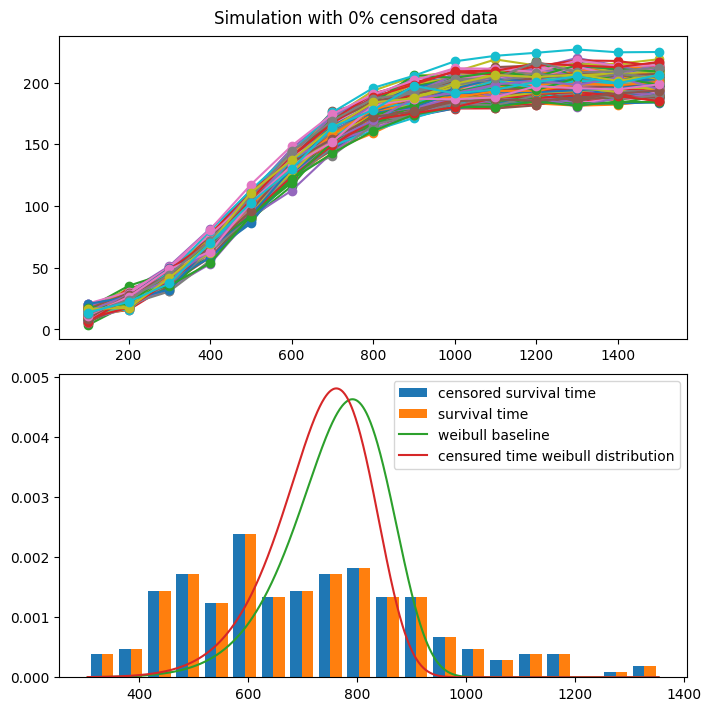

In [11]:
fig, ax = plot_sample(myobs, mysim, censoring_loc=770, **myModel._cst)

### Estimation

In [ ]:
from sdg4varselect.algo import StochasticGradientDescentPrecond as SPG
import sdg4varselect.algo.preconditioner as preconditioner

FIM = preconditioner.Fisher()
algo = SPG(FIM, partial_fit=True)
algo.init_mcmc(myModel, adaptative_sd=True)

In [13]:
algo.step_size = FIM._step_size_fisher
algo.step_size.heating.step = algo.max_iter - 1000

FIM._step_size_fisher, FIM._step_size_approx_sto, algo.step_size

(Learning rate [preheating(step : 1000, coef = -18.42068099975586), heating(step : 4000, coef = 0.65), max = 0.9],
 Learning rate [preheating(step : 1000, coef = -18.42068099975586), heating(step : nan, coef = 0.65), max = 1],
 Learning rate [preheating(step : 1000, coef = -18.42068099975586), heating(step : 4000, coef = 0.65), max = 0.9])

In [14]:
prngkey = jrd.PRNGKey(0)
prngkey_theta, prngkey = jrd.split(prngkey)
theta0 = jrd.normal(prngkey_theta, shape=(myModel.parametrization.size,))

res = algo.fit(myModel, myobs, theta0)
print(res.chrono)

0:00:55.022490


/home/acaillebotte/projects/packages/sdg4varselect/sdg4varselect/algo/sto_grad_descent_precond.py:143: UserWarning: 
The algorithm may not have converged, 3 components of the gradient of the log marginal likelihood are not sufficiently small
  warnings.warn(


In [15]:
res.theta_star = p_star

In [16]:
import numpy as np

p_names = np.array(
    [
        "$\\mu_1$",
        "$\\mu_2$",
        "$\\tau$",
        "$\\gamma^2_1$",
        "$\\gamma^2_12$",
        "$\\gamma^2_21$",
        "$\\gamma^2_2$",
        "$\\sigma^2$",
        "$\\alpha$",
        # "a",
        # "b",
        "$\\beta_1$",
        "$\\beta_2$",
        "$\\beta_3$",
        "$\\beta_4$",
    ]
)

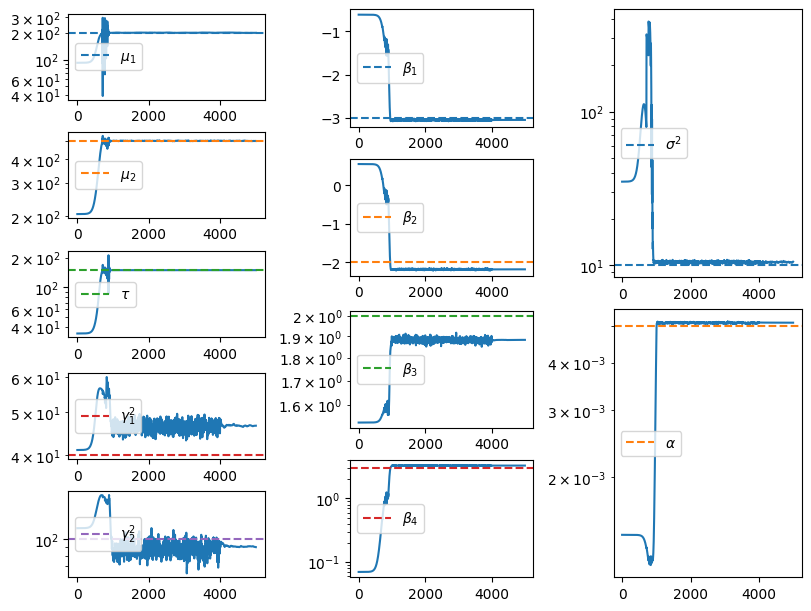

In [17]:
from sdg4varselect.outputs import MultiGDResults

fig = sdgplt.figure(6, 8)
# top, bottom = fig.subfigures(2, 1, wspace=0.0007, height_ratios=[2, 2])

_ = sdgplt.plot_theta(
    res,
    fig=[*fig.subfigures(1, 3)],  # [*top.subfigures(1, 2), bottom],
    params_names=p_names,
    id_to_plot=[
        [0, 1, 2, 3, 6],
        [9, 10, 11, 12],  # , 13, 14],
        [7, 8],  # , 9, 10],
    ],
)

#### Simulation with the estimate

In [18]:
p_hat = res.last_theta
p_hat = myModel.new_params(
    mean_latent={"mu_1": p_hat[0], "mu_2": p_hat[1]},
    tau=p_hat[2],
    cov_latent=jnp.diag(jnp.array([p_hat[3], p_hat[6]])),
    var_residual=p_hat[7],
    alpha=p_hat[8],
    # a=p_hat[9],
    # b=p_hat[10],
    beta=p_hat[-4:],
)

sim_obs, sim_sim = myModel.sample(
    p_hat,
    jrd.PRNGKey(0),
    weibull_censoring_loc=770,
    simulation_intervalle=[0, 10000],
)

In [19]:
fig, ax = plot_sample(
    sim_obs, sim_sim, censoring_loc=myModel._cst["a"], a=p_hat.a, b=p_hat.b
)

AttributeError: 'Parameters' object has no attribute 'a'